In [10]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline
import matplotlib.cm as cm
import seaborn as sns
sns.set_style("dark")

from yellowbrick.cluster import KElbowVisualizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler

# Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture as EM

# Dim reduction
from sklearn.decomposition import PCA, FastICA, TruncatedSVD
from sklearn.random_projection import SparseRandomProjection, GaussianRandomProjection
from scipy.stats import kurtosis 

# Models
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score

from sklearn.datasets import load_digits
from utils import learning_curve_plotter, model_param_curve, metrics

In [11]:
seed = 777

In [12]:
# Diabet Load Dataset

diabet_path = "./data/diabetes.csv"
df_diabet = pd.read_csv(diabet_path)

target = 'Outcome'
features = [ 'Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age']

X_origin, y = df_diabet[features], df_diabet[target]

# data normalize
sc = MinMaxScaler()
sc.fit(X_origin)

X = sc.transform(X_origin)
X_df = pd.DataFrame(X)
df_diabet = pd.concat([X_df, y], axis=1)

In [22]:
# Load Dataset

mnist = load_digits()

# fig, axes = plt.subplots(2, 10, figsize=(16, 6))
# for i in range(20):
#     axes[i//10, i %10].imshow(mnist.images[i], cmap='gray');
#     axes[i//10, i %10].axis('off')
#     axes[i//10, i %10].set_title(f"target: {mnist.target[i]}")
    
# plt.tight_layout()

# data normalize
sc = MinMaxScaler()
sc.fit(mnist.data)

X = sc.transform(mnist.data)
X_df = pd.DataFrame(X)
y_target = pd.DataFrame(mnist.target)
df_digit = pd.concat([X_df, y_target], axis=1)

# Dimensionality Reduction

In [14]:
# df_diabet, df_digit

In [40]:
def calc_score_func(df, dim=2, mode="None", cv=3):

    nn_clf = MLPClassifier(random_state=seed, max_iter=1000, early_stopping=False, activation="tanh")
    
    if mode == "mlp":
        X_feature = df.iloc[:,:-1]
    elif mode == "pca":
        pca = PCA(random_state=seed, n_components=dim)
        X_feature = pca.fit_transform(df.iloc[:,:-1])
    elif mode == "ica":
        ica = FastICA(random_state=seed, n_components=dim).fit(df.iloc[:,:-1])
        X_feature = ica.fit_transform(df.iloc[:,:-1])
    elif mode == "rp":
        rp = SparseRandomProjection(random_state=seed, n_components=dim)
        X_feature = rp.fit_transform(df.iloc[:,:-1])
    elif mode == "tsvd":
        tsvd = TruncatedSVD(n_components=dim, random_state=seed)
        X_feature = tsvd.fit_transform(df.iloc[:,:-1])

    scores = cross_val_score(nn_clf, X_feature, df.iloc[:,-1], scoring="accuracy", cv=cv).mean()
    
    return scores

In [27]:
# Clustering 시각화 → DR 진행 → DR + Clustering → DR + NN (Assign #1) → DR + Clustering + NN
# https://wjddyd66.github.io/handson/Ch8.Dimensionality_Reduction/

dim = 2

def mlp_classifer(df, hidden_size=30, lr=0.1, max_iter=1000):
    # best parameter tester
    nn_clf = MLPClassifier(
        random_state=seed,
        hidden_layer_sizes=hidden_size,
        learning_rate_init=lr,
        max_iter=max_iter
    )
    
    nn_clf.fit(df.iloc[:,:-1], df.iloc[:,-1])
    
    return nn_clf

mlp_classifer(df_digit)
mlp_classifer(df_diabet)

MLPClassifier(hidden_layer_sizes=30, learning_rate_init=0.1, max_iter=1000,
              random_state=777)

## PCA

In [28]:
def kurtosis_val(df):
    return kurtosis(df.iloc[:,-1])

print(f"diabet: {kurtosis_val(df_diabet)}")
print(f"digit: {kurtosis_val(df_digit)}")

diabet: -1.5983283582089547
digit: -1.2147296065623656


8


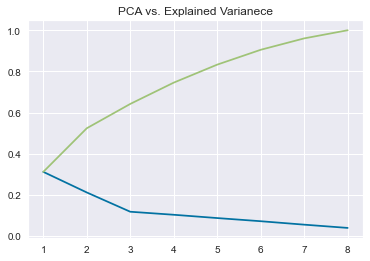

64


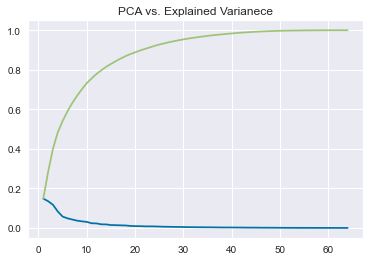

In [35]:
# cumsum = np.cumsum(pca.explained_variance_ratio_)
# print(cumsum)
# d = np.argmax(cumsum >= 0.95) + 1
# print(d)

def pca_explained_var(df):

    print(len(df.columns)-1)
    
    pca = PCA(random_state=seed, n_components=(len(df.columns)-1)).fit(df.iloc[:,:-1])
    plt.grid()
    plt.title("PCA vs. Explained Varianece")
#     plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
    plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_))
    plt.show()
    plt.close()


pca_explained_var(df_diabet)
pca_explained_var(df_digit)

In [37]:
def plot_func(df, dim=2, mode="None"):
    
    if mode == "pca":
        pca = PCA(random_state=seed, n_components=dim)
        X_feature = pca.fit_transform(df.iloc[:,:-1])
    elif mode == "ica":
        ica = FastICA(random_state=seed, n_components=dim)
        X_feature = ica.fit_transform(df.iloc[:,:-1])
    elif mode == "rp":
        rp = SparseRandomProjection(random_state=seed, n_components=dim)
        X_feature = rp.fit_transform(df.iloc[:,:-1])
    elif mode == "tsvd":
        tsvd = TruncatedSVD(n_components=2, random_state=seed)
        X_feature = tsvd.fit_transform(df.iloc[:,:-1])
        
    y = df.iloc[:,-1]
    
    plt.figure(figsize=(25, 16))
    plt.grid()
    plt.title(mode)
    
    plt.scatter(X_feature[:,0], X_feature[:,1], c=y, alpha=0.7, s=50)
    
#     for i in range(0, dim):
#         for j in range(0, dim):
#             if i == j:
#                 continue
#             plt.scatter(X_feature[:,i], X_feature[:,j], alpha=0.5, s=20)
    
    plt.show()
    plt.close()

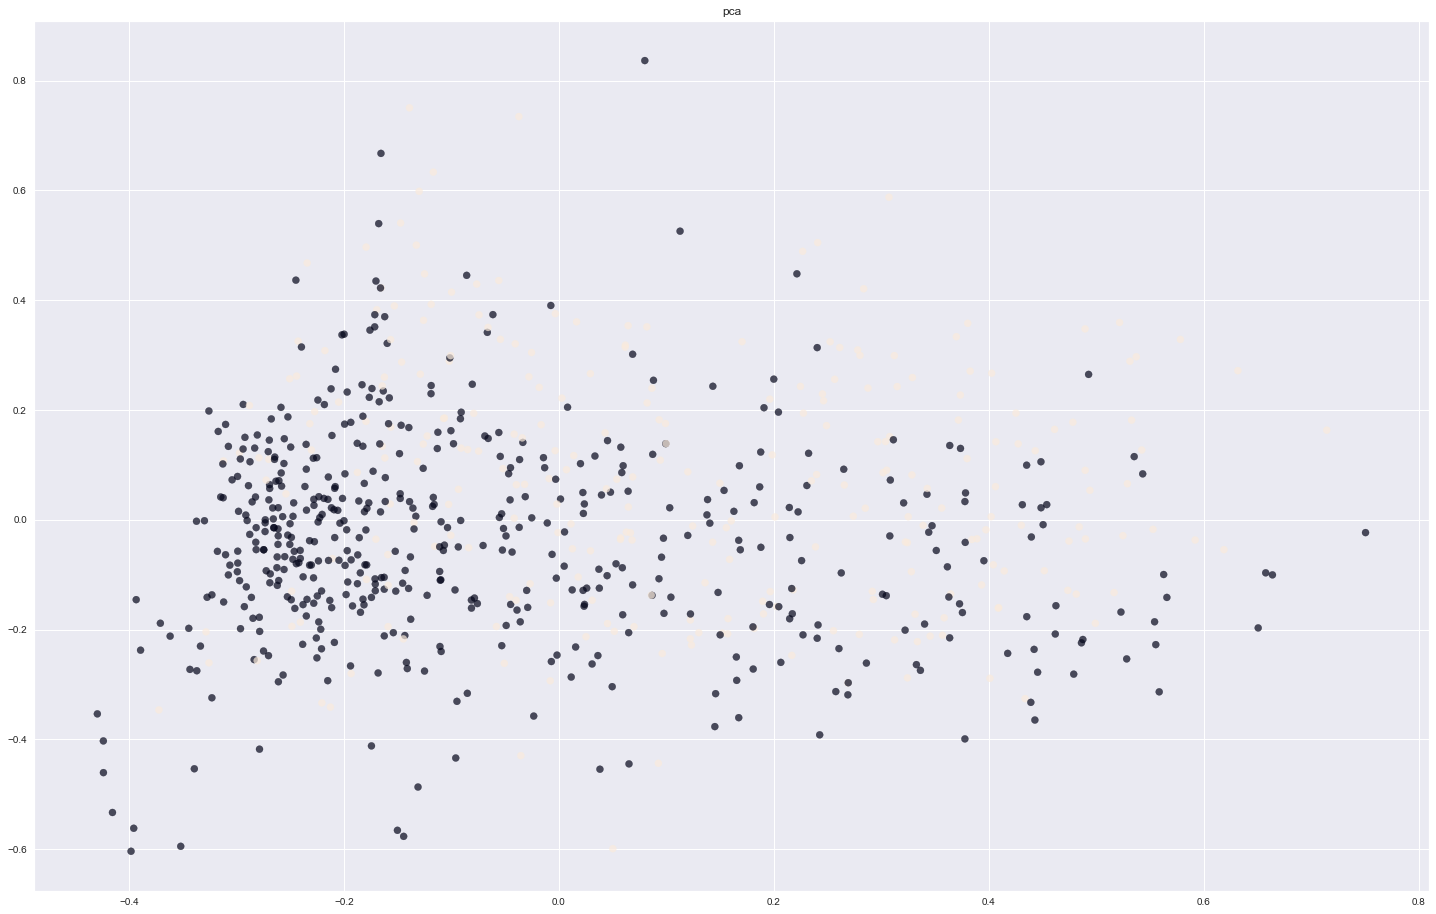

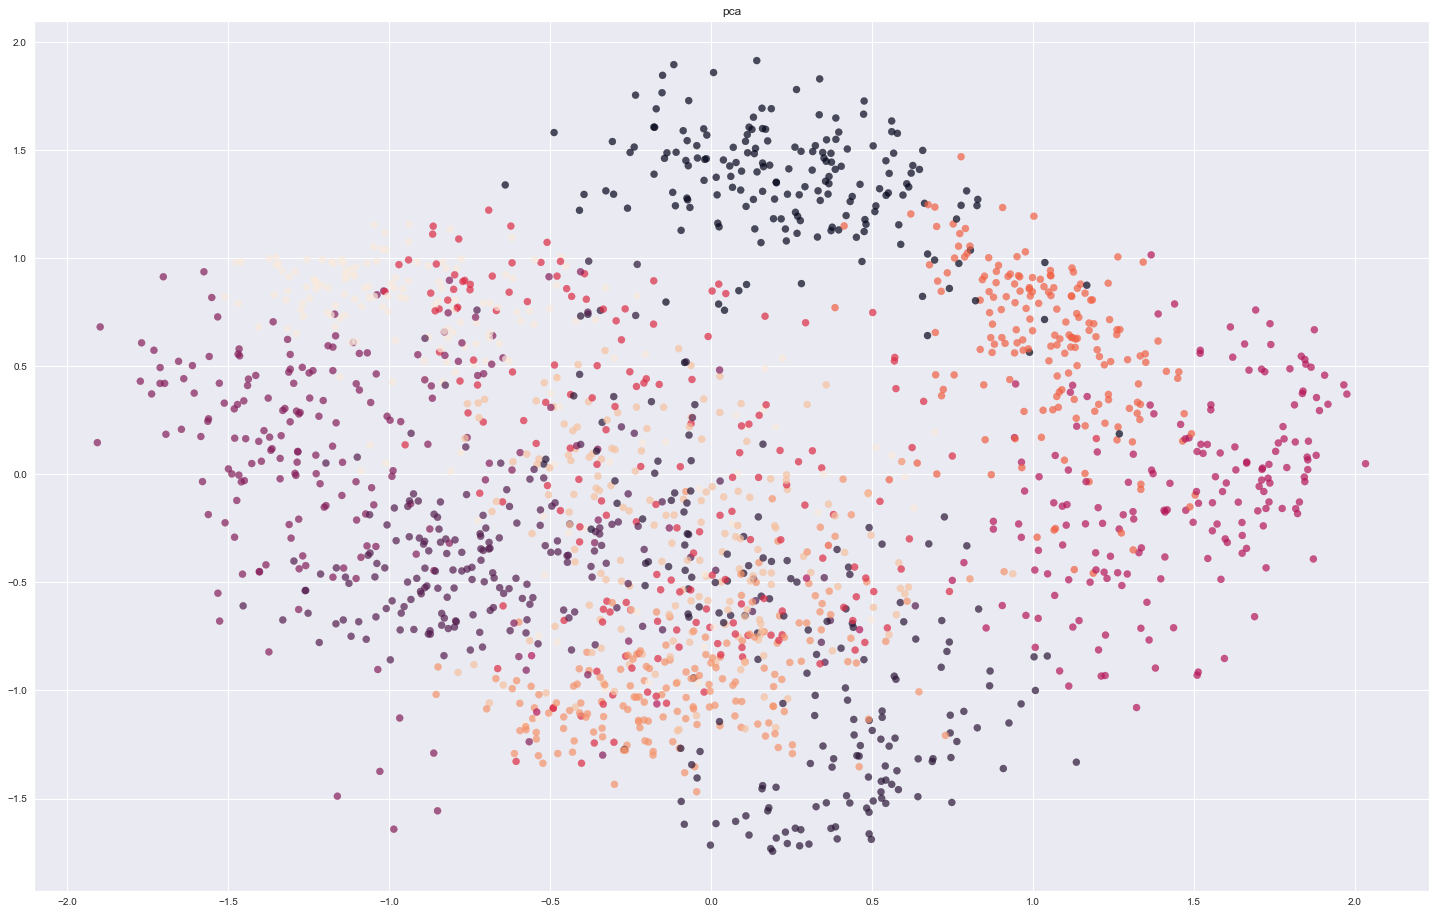

In [39]:
plot_func(df_diabet, dim=3, mode="pca")
plot_func(df_digit, dim=50, mode="pca")

mlp_diabet_score = calc_score_func(df_diabet, mode="mlp")
mlp_digit_score = calc_score_func(df_digit, mode="mlp")
print(mlp_diabet_score)
print(mlp_digit_score)

pca_diabet_score = calc_score_func(df_diabet, mode="pca")
pca_digit_score = calc_score_func(df_digit, mode="pca")
print(pca_diabet_score)
print(pca_digit_score)


0.7330729166666666
0.4023372287145242


## ICA

In [57]:


def dr_score(df, dim_range, gap=1, mode="None"):
    results = []
    for i in range(2, dim_range, 1):
        score = calc_score_func(df, dim=i, mode=mode)
        results.append([i, score])
        
    return sorted(results)

# ica_diabet_score = dr_score(df_diabet, dim_range=8, mode="ica")
ica_digit_score = dr_score(df_digit, dim_range=30, gap=2, mode="ica")
# print(ica_diabet_score)
# print(ica_digit_score)

/Users/user/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/Users/user/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/Users/user/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/user/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/Users/user/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/

In [58]:
print(ica_digit_score)

[[2, 0.5915414579855315], [3, 0.687813021702838], [4, 0.7790762381747357], [5, 0.8185865331107401], [6, 0.8302726766833611], [7, 0.8569838619922092], [8, 0.8731218697829716], [9, 0.889259877573734], [10, 0.8898163606010017], [11, 0.904284919309961], [12, 0.902615470228158], [13, 0.905954368391764], [14, 0.905954368391764], [15, 0.9087367835281023], [16, 0.910962715637173], [17, 0.9165275459098498], [18, 0.9143016138007791], [19, 0.9126321647189761], [20, 0.9104062326099055], [21, 0.9154145798553145], [22, 0.9165275459098498], [23, 0.9143016138007791], [24, 0.9154145798553145], [25, 0.9176405119643851], [26, 0.9170840289371175], [27, 0.9215358931552587], [28, 0.9159710628825821], [29, 0.912632164718976]]


In [142]:
# plot_func(df_diabet, dim=2, mode="ica")
# # plot_func(df_digit, dim=2, mode="ica")

# plot_func(df_diabet, dim=2, mode="rp")
# plot_func(df_digit, dim=2, mode="rp")

# plot_func(df_diabet, dim=2, mode="tsvd")
# plot_func(df_digit, dim=2, mode="tsvd")

# ica_diabet_score = calc_score_func(df_diabet, mode="ica")
# ica_digit_score = calc_score_func(df_digit, mode="ica")
# print(ica_diabet_score)
# print(ica_digit_score)

# rp_diabet_score = calc_score_func(df_diabet, mode="rp")
# rp_digit_score = calc_score_func(df_digit, mode="rp")
# print(rp_diabet_score)
# print(rp_digit_score)

# tsvd_diabet_score = calc_score_func(df_diabet, mode="tsvd")
# tsvd_digit_score = calc_score_func(df_digit, mode="tsvd")
# print(tsvd_diabet_score)
# print(tsvd_digit_score)

## Randomized Projections

## Truncated SVD